#### Gradient inference with functional observations in gpytorch (spatial confounding example)

In this notebook, we demonstrate the inference of gradient (marginal effect) from functional observations with spatial confounding, training an RBF kernel Gaussian process. We use 2-dimensional covariate and longitudal/latitudal confoundings.

In [1]:
# LOAD PACKAGES
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.models.exact_prediction_strategies import prediction_strategy
from gpytorch.means.mean import Mean
from gpytorch.kernels.kernel import Kernel
from gpytorch.lazy import InterpolatedLazyTensor
from gpytorch.utils.broadcasting import _mul_broadcast_shape
from sklearn.gaussian_process.kernels import RBF
from numpy.random import multivariate_normal

Set up data n = 1000, D = 2 with spatial confounding locations (longitude,latitude)

$x_{i}\in \mathbb{R}^D$ 

$y_{i} = \sum\limits_{d=1}^D \sin(x_{i}*d)/d + f(s_{i}) + \varepsilon, \quad s_{i}\in\mathbb{R}^2$

$f\sim\mathbb{GP}(0,K_f)$

$K_f(s,s')=\exp(-\frac{||s-s'||^2}{2\ell^2})$

$\varepsilon\sim\mathbb{N}(0,0.1^2)$

In [2]:
# define data
D = 2
n = 1000
torch.random.manual_seed(12345)
noise_sd = 0.1
soboleng = torch.quasirandom.SobolEngine(dimension=D)
train_x = 4*soboleng.draw(n)-2
train_s = 4*soboleng.draw(n)-2

# generate spatial effect
spatial_kernel = RBF(length_scale=1)
spatial_cov = spatial_kernel(X=train_s) + 1e-6*np.eye(n)
spatial_effects = torch.tensor(multivariate_normal(np.zeros((n,)),spatial_cov))

train_y = torch.randn(n) * noise_sd
train_y += spatial_effects

# covariate effect
ARD_lss = 1 + torch.arange(D)
for k in range(D):
    train_y += torch.sin(train_x[:,k]*ARD_lss[k])/ARD_lss[k]

3d visualization of spatial effect

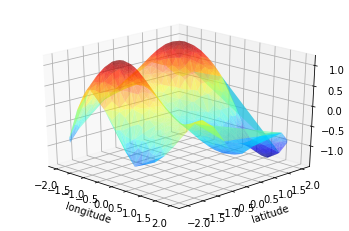

In [10]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.figure().add_subplot(projection='3d')
ax.plot_trisurf(train_s[:,0], train_s[:,1], spatial_effects, cmap='jet', alpha=0.5)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_zlabel("spatial effect")
ax.view_init(elev=25, azim=-45)

contour plot of spatial effect

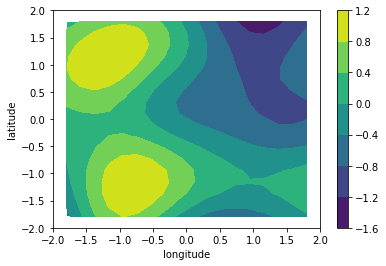

In [28]:
from scipy import interpolate

# Create interpolator:
ndpol = interpolate.LinearNDInterpolator(train_s, spatial_effects)

# Create meshgrid:
xl = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(xl, xl)
lims = [xl.min(), xl.max(), xl.min(), xl.max()]

# Interpolate over meshgrid:
V = ndpol(list(zip(X.ravel(),Y.ravel()))).reshape(X.shape)

ax = plt.contourf(X, Y, V)
plt.xlabel("longitude")
plt.ylabel("latitude")
cbar = plt.colorbar(ax)

define a GP model with linear mean and sqrexp ARD kernel with gradient; add a zero-meaned GP model for spatial confounding

In [31]:
class DerivativeExactGP(gpytorch.models.ExactGP):
    """Derivative of the ExactGPModel w.r.t. the test points x.
    Since differentiation is a linear operator this is again a Gaussian process.
    Attributes:
        train_x: (N x D) The training features X.
        train_s: (N x 2) The training spatial confounding s.
        likelihood: gpytorch likelihood.
    """

    def __init__(
        self,
        train_x=None,
        train_s=None,
        train_y=None,
        likelihood=None
    ):
        """Inits GP model with data and a Gaussian likelihood."""
        if likelihood is None:
            likelihood = GaussianLikelihood()
        if train_y is not None:
            train_y = train_y.squeeze(-1)
        super(DerivativeExactGP, self).__init__((train_x,train_s), train_y, likelihood)

        self.D = train_x.shape[1]
        self.N = train_x.shape[0]

        # dynamic time effects
        self.s_covar_module = ScaleKernel(RBFKernel())

        # covariate effect with linear mean and sqrexp ARD kernel
        self.mean_module = LinearMean(input_size=self.D)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=self.D))

    def forward(self, x, s):
        """Compute the prior latent distribution on a given input.
        Typically, this will involve a mean and kernel function. The result must be a
        MultivariateNormal. Calling this model will return the posterior of the latent
        Gaussian process when conditioned on the training data. The output will be a
        MultivariateNormal.
        Args:
            x: (n x D) The test points.
            s: (n x 2) The test spatial locations.
        Returns:
            A MultivariateNormal.
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x) + self.s_covar_module(s)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def get_L_lower(self):
        """Get Cholesky decomposition L, where L is a lower triangular matrix.
        Returns:
            Cholesky decomposition L.
        """
        return (
            self.prediction_strategy.lik_train_train_covar.root_decomposition()
            .root.evaluate()
            .detach()
        )

    def get_KXX_inv(self):
        """Get the inverse matrix of K(X,X).
        Returns:
            The inverse of K(X,X).
        """
        L_inv_upper = self.prediction_strategy.covar_cache.detach()
        return L_inv_upper @ L_inv_upper.transpose(0, 1)

    def get_KXX_inv_old(self):
        """Get the inverse matrix of K(X,X).
        Not as efficient as get_KXX_inv.
        Returns:
            The inverse of K(X,X).
        """
        X = self.train_inputs[0]
        sigma_n = self.likelihood.noise_covar.noise.detach()
        KXX = torch.eye(X.shape[0]) * sigma_n + self.covar_module(X).evaluate()
        return torch.inverse(KXX)

    def _get_KxX_dx(self, x):
        """Computes the analytic derivative of the kernel K(x,X) w.r.t. x.
        Args:
            x: (n x D) Test points.
        Returns:
            (n x D) The derivative of K(x,X) w.r.t. x.
        """
        X = self.train_inputs[0]
        n = x.shape[0]
        K_xX = self.covar_module(x, X).evaluate()
        lengthscale = self.covar_module.base_kernel.lengthscale.detach()
        return (
            -torch.eye(self.D, device=x.device)
            / lengthscale ** 2
            @ (
                (x.view(n, 1, self.D) - X.view(1, self.N, self.D))
                * K_xX.view(n, self.N, 1)
            ).transpose(1, 2)
        )

    def _get_Kxx_dx2(self):
        """Computes the analytic second derivative of the kernel K(x,x) w.r.t. x.
        Args:
            x: (n x D) Test points.
        Returns:
            (n x D x D) The second derivative of K(x,x) w.r.t. x.
        """
        lengthscale = self.covar_module.base_kernel.lengthscale.detach()
        sigma_f = self.covar_module.outputscale.detach()
        return (
            torch.eye(self.D, device=lengthscale.device) / lengthscale ** 2
        ) * sigma_f

    def _get_mu_dx(self, x):
        """Get the derivative of mu(x).
        Returns:
            The gradient of linear mu(x) wrt x.
        """
        return self.mean_module.weights.expand(x.t().shape).t() # x.grad.data.reshape((-1,self.D))

    def posterior_derivative(self, x):
        """Computes the posterior of the derivative of the GP w.r.t. the given test
        points x.
        Args:
            x: (n x D) Test points.
        Returns:
            A GPyTorchPosterior.
        """
        mu_x_dx = self._get_mu_dx(x)

        with torch.no_grad():
            if self.prediction_strategy is None:
                train_output = super().__call__(self.train_inputs)
                # Create the prediction strategy for
                self.prediction_strategy = prediction_strategy(
                    train_inputs=self.train_inputs,
                    train_prior_dist=train_output,
                    train_labels=self.train_targets,
                    likelihood=self.likelihood,
                )

            K_xX_dx = self._get_KxX_dx(x)
            mu_prior = self.mean_module(self.train_inputs[0])
            mean_d = mu_x_dx + K_xX_dx @ self.get_KXX_inv() @ (self.train_targets - mu_prior)
            variance_d = (
                self._get_Kxx_dx2() - K_xX_dx @ self.get_KXX_inv() @ K_xX_dx.transpose(1, 2)
            )
            variance_d = variance_d.clamp_min(1e-8)

        return mean_d, variance_d

define likelihood and derivativeExactGP model

In [32]:
likelihood = GaussianLikelihood()
model = DerivativeExactGP(train_x,train_s, train_y, likelihood)

learn hyperparameter by minimizing the negative log likelihood using ADAM optimizer

In [33]:
# train
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x,train_s)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  slope: %.3f   lengthscale: %.3f  outputscale: %.3f  noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.mean_module.weights[0].item(),
        model.covar_module.base_kernel.lengthscale[0,0].item(),
        model.covar_module.outputscale.item(),
        likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.929  slope: -0.877   lengthscale: 0.693  outputscale: 0.693  noise: 0.693
Iter 2/50 - Loss: 0.870  slope: -0.777   lengthscale: 0.744  outputscale: 0.744  noise: 0.644
Iter 3/50 - Loss: 0.814  slope: -0.678   lengthscale: 0.798  outputscale: 0.797  noise: 0.598
Iter 4/50 - Loss: 0.768  slope: -0.581   lengthscale: 0.854  outputscale: 0.850  noise: 0.554
Iter 5/50 - Loss: 0.710  slope: -0.485   lengthscale: 0.911  outputscale: 0.903  noise: 0.513
Iter 6/50 - Loss: 0.665  slope: -0.392   lengthscale: 0.969  outputscale: 0.956  noise: 0.474
Iter 7/50 - Loss: 0.621  slope: -0.303   lengthscale: 1.028  outputscale: 1.008  noise: 0.437
Iter 8/50 - Loss: 0.577  slope: -0.216   lengthscale: 1.086  outputscale: 1.057  noise: 0.402
Iter 9/50 - Loss: 0.533  slope: -0.134   lengthscale: 1.145  outputscale: 1.105  noise: 0.370
Iter 10/50 - Loss: 0.494  slope: -0.056   lengthscale: 1.204  outputscale: 1.149  noise: 0.340
Iter 11/50 - Loss: 0.448  slope: 0.017   lengthscale: 1.262

plot partial gradients

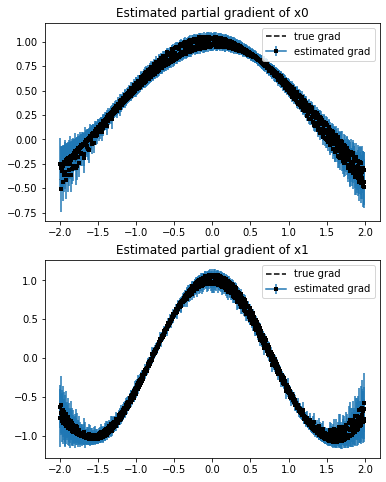

In [35]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x, train_s))

with torch.no_grad():
    mean_d, variance_d = model.posterior_derivative(train_x)
    variance_d = torch.diagonal(variance_d, dim1=1,dim2=2)
    
_, ax = plt.subplots(nrows=2,ncols=1,figsize=(6, 8))

for k in range(D):
    sorted, idx = torch.sort(train_x[:,k])
    ax[k].plot(sorted.numpy(), torch.cos(sorted*ARD_lss[k]).numpy(), '--k',label='true grad')
    ax[k].errorbar(sorted.numpy(), mean_d[idx,k].numpy(), yerr=2*variance_d[idx,k].numpy()**0.5,\
            marker='s', mfc='red', mec='black', ms=2, mew=2,label='estimated grad')

    ax[k].legend()
    ax[k].set_title('Estimated partial gradient of x' + str(k))

plt.show()

visualize estimated spatial confounding